In [35]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding,GRU
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from keras.models import load_model
from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

## Read  Dataset

In [20]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


## Split Dataset Train & Validation

In [21]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [22]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [23]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [24]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [25]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [26]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [27]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [28]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

## Hyperparameters

In [29]:
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
number_of_units=50
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=0.2

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(model_FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)
nadam = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [31]:
model = Sequential()
model.add(GRU(number_of_units, return_sequences=True,kernel_initializer = randomInit, bias_initializer = randomInit,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(GRU(number_of_units, return_sequences=True))
model.add(Dropout(dropout))
model.add(GRU(int(number_of_units)))
model.add(Dropout(dropout))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 1, 50)             11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1, 50)             15150     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1377      
Total para

In [32]:
#Time to train

start_time = time.time()




history=model.fit(X_train, Y_train, epochs=Epochs, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))






Train on 216000 samples, validate on 54000 samples
Epoch 1/30
216000/216000 [==============================] - 167s 771us/step - loss: 2.0869 - acc: 0.3128 - val_loss: 1.7692 - val_acc: 0.3962

Epoch 00002: val_acc improved from 0.30215 to 0.39617, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/30
216000/216000 [==============================] - 164s 760us/step - loss: 1.8897 - acc: 0.3601 - val_loss: 1.6013 - val_acc: 0.4379

Epoch 00003: val_acc improved from 0.39617 to 0.43785, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/30
216000/216000 [==============================] - 157s 728us/step - loss: 1.7669 - acc: 0.3908 - val_loss: 1.5507 - val_acc: 0.4353

Epoch 00004: val_acc did not improve
Epoch 5/30
216000/216000 [==============================] - 156s 720us/step - loss: 1.6716 - acc: 0.4181 - val_loss: 1.4825 - val_acc: 0.4660

Epoch 00005: val_acc improved from 0.43785 to 0.46604, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
E

In [33]:
model.save(model_FileName[:-3])  # creates a HDF5 file 'my_model.h5'


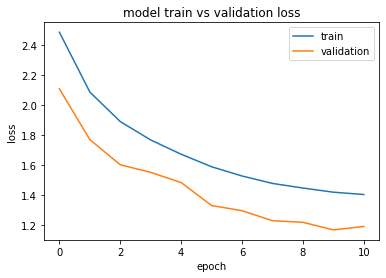

In [36]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

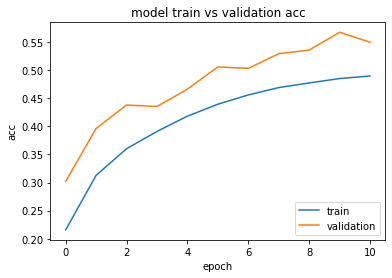

In [37]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [38]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [39]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [40]:
Y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## TEST DEĞERLENDİRME

In [41]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
predicted = model.predict(X_test)

81000/81000 [==============================] - 12s 143us/step
Loss for testing = 1.2388704817934122 and Accuracy for testing = 0.5407407426778917


In [42]:
(predicted.shape)

(81000, 27)

In [43]:
#predicted = model.predict(X_test)

In [44]:
(predicted.shape)

(81000, 27)

### grafik mırafik

In [45]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return df_confusion

In [46]:
predicted

array([[9.9999750e-01, 7.3152431e-09, 3.9386322e-08, ..., 8.4428321e-14,
        1.2912109e-11, 1.2470047e-06],
       [9.9995625e-01, 2.3747245e-06, 1.9104352e-06, ..., 3.6453102e-12,
        1.5089420e-09, 2.6996357e-05],
       [8.5505322e-02, 5.9175603e-03, 3.9031054e-04, ..., 3.1412967e-02,
        9.6162185e-03, 3.2119408e-01],
       ...,
       [4.7669858e-01, 4.6441960e-03, 1.7008421e-04, ..., 4.5247524e-04,
        3.3030873e-03, 4.2340374e-01],
       [3.4977850e-01, 1.9243762e-03, 2.3137009e-05, ..., 3.6398684e-05,
        1.9066765e-04, 3.2240796e-01],
       [4.7671685e-01, 4.6417261e-03, 1.7008644e-04, ..., 4.5237847e-04,
        3.3025004e-03, 4.2340797e-01]], dtype=float32)

In [47]:
print(predicted.shape, Y_test.shape)

(81000, 27) (81000, 27)


Average F1 score is 0.5324710913895823
Confusion matrix: 
 Predicted    0     1     2     3    4   5    6    7     8     9   ...   17  \
Actual                                                            ...        
0          1947     0     0     0    0   0    0    0     0     0  ...  117   
1             1  2115   110     0   28   1   37    8   397    27  ...   16   
2            19     0  1933     0    0   0    0    0     0   735  ...   88   
3            32     1    32  2609    0   0    0    0   178    29  ...    0   
4             4   273     5     0  777  37  258  331   776     0  ...    0   
5            15   163    19     0   66  80  598  303  1325    13  ...    7   
6             9   188    27     0   81  51  575  198  1455    11  ...    6   
7             6   184    30     0  112  57  540  343  1351     7  ...    5   
8            10   172    30     0   85  64  532  248  1409     7  ...    6   
9            41     0   402     0    0   0    0    0     0  2187  ...  121   
10   

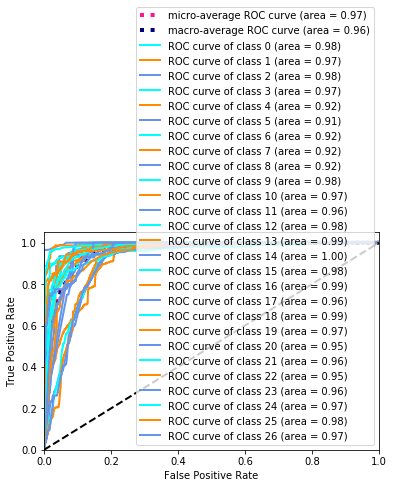

In [48]:
df=compute_metrics(predicted, Y_test)

In [49]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [50]:
cm=matrix

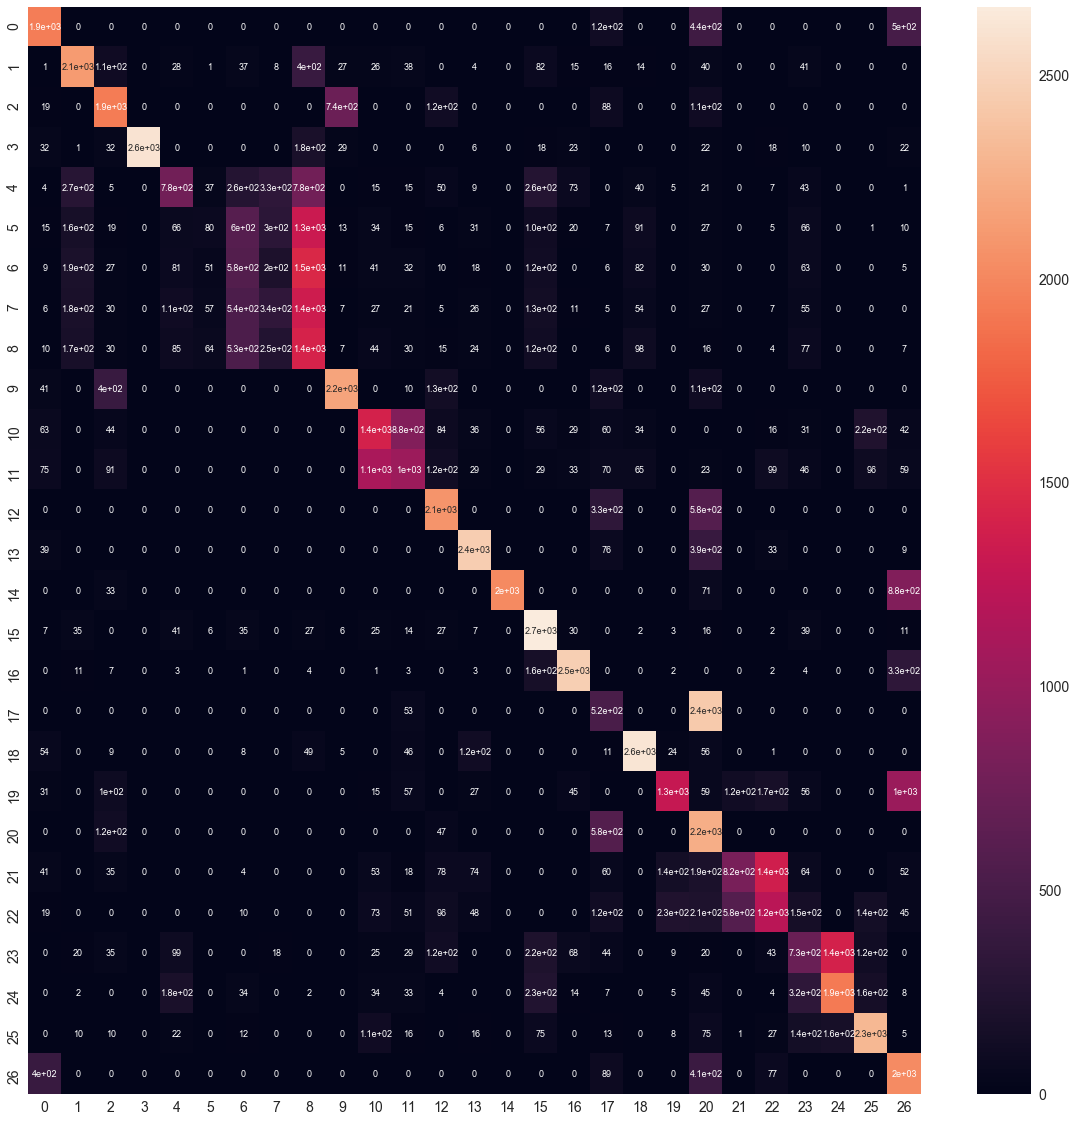

In [51]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

 ## blove part taken from https://www.python-course.eu/confusion_matrix.php

In [52]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     0.693  0.649  0.670
    1     0.666  0.705  0.685
    2     0.628  0.644  0.636
    3     1.000  0.870  0.930
    4     0.521  0.259  0.346
    5     0.270  0.027  0.049
    6     0.217  0.192  0.204
    7     0.237  0.114  0.154
    8     0.202  0.470  0.283
    9     0.722  0.729  0.726
   10     0.460  0.466  0.463
   11     0.432  0.346  0.384
   12     0.696  0.694  0.695
   13     0.837  0.817  0.827
   14     1.000  0.674  0.805
   15     0.624  0.889  0.733
   16     0.872  0.822  0.846
   17     0.220  0.173  0.194
   18     0.845  0.873  0.859
   19     0.754  0.431  0.549
   20     0.293  0.749  0.421
   21     0.537  0.273  0.362
   22     0.394  0.408  0.401
   23     0.376  0.243  0.295
   24     0.551  0.639  0.592
   25     0.758  0.769  0.763
   26     0.403  0.676  0.505


In [53]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

0.5407407407407407

## MODEL SAVING RELOADING

In [54]:
from keras.models import load_model
model.save(model_FileName)  # creates a HDF5 file 'my_model.h5'



In [55]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')

OSError: Unable to open file (unable to open file: name = '54.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
len(predicted)

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:


ths =open( "y_and_p_compare.csv", "w")


counter=-1
for i in range (len(predicted)):
    float_formatter = "{:.2f}".format
    print(Y_test[i],predicted[i])
    
    y= str(counter)+"-"+str(i)+"-            "+str(Y_test[i])
    y=y.replace("\n","")
    y=y+"\n"
    p=  str(counter)+"-"+str(i)+"-            "+str(predicted[i])
    p=p.replace("\n","")
    p=p+"\n"
    ths.write(y)
    ths.write(p)
    ths.write("\n")
    
    if i%50==0:
        counter=counter+1
        print(counter)
ths.close()        